# La Ciudad desde los Datos


**Pensar computacionalmente**

¿Se puede hacer una lectura de la ciudad a partir de la información que ella misma genera?

Y si es así, ¿cuál sería la mejor forma de hacerlo?

A decir verdad, trabajar la ciudad desde una prespectiva computacional no es sólo recopilar información o automatizar procesos. 

Pensar computacionalmente implica diseñar, construir y manipular los objetos con los que vamos a trabajar. Entender cómo se comportan. Si aumentan, si disminuyen, si se acercan, si se alejan, si se concentran, si se dispersan, etc.  

En otras palabras, pensar computacionalmente es también una forma de plantearnos interrogantes y de responderlos.

# ¡Problemas computacionales!

Una de las ventajas de pensar un problema programáticamente, es que podemos definir de manera ordenada y secuencial los pasos que debemos completar para dar respuesta a una pregunta. 

Pensemos por un momento en algún problema de accesibilidad. Por ejemplo, a escuelas ...

In [2]:
#!pip install pandana
#!pip install osmnet

In [3]:
from google.colab import drive
drive.mount("/drive/")

Mounted at /drive/


In [4]:
import pandas as pd

import pandana
print(pandana.__version__)

0.6.1


In [5]:
from pandana.loaders import osm

import warnings
warnings.filterwarnings('ignore')

### 1. Creo una red vial y determino puntos de interés.

In [6]:
bbox = [-34.59735464,-58.61822155,-34.49018807,-58.50991202] 
network = osm.pdna_network_from_bbox(bbox[0],bbox[1],bbox[2],bbox[3]) 

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](-34.59735464,-58.61822155,-34.49018807,-58.50991202);>;);out;'}"
Downloaded 4,725.5KB from www.overpass-api.de in 3.97 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 4.05 seconds
Returning OSM data with 27,297 nodes and 8,736 ways...
Edge node pairs completed. Took 12.38 seconds
Returning processed graph with 14,272 nodes and 23,743 edges...
Completed OSM data download and Pandana node and edge table creation in 17.02 seconds


In [7]:
target_tags = ['"amenity"~"school"', '"leisure"~"park"', '"amenity"~"restaurant|bar"']

In [8]:
# creo un objeto para guardar la consulta de los resultados de mi query
tpois = osm.node_query(bbox[0],bbox[1],bbox[2],bbox[3], 
                       tags=target_tags[0])

In [9]:
# ahora, puedo asociarlo a mi red vial
network.set_pois(category = 'tpois',
                 maxdist = 1000,
                 maxitems = 3,
                 x_col = tpois.lon, 
                 y_col = tpois.lat)

In [10]:
# y encontrar los n puntos mas cercanos en un radio de distancia x a los nodos de la red
results = network.nearest_pois(distance = 1000,
                               category = 'tpois',
                               num_pois = 3,
                               include_poi_ids = True)
results.head()

,1,2,3,poi1,poi2,poi3
id,,,,,,
29647104,1000.000000,1000.000000,1000.000000,NaN,NaN,NaN
29652262,200.731003,1000.000000,1000.000000,2.189023e+09,NaN,NaN
30491461,276.770996,500.558990,893.182007,5.080345e+09,5.757545e+09,8.132941e+09
32724528,141.274002,485.184998,668.697998,5.757545e+09,8.132941e+09,5.080345e+09
32724531,148.819000,548.396973,1000.000000,8.132941e+09,5.757545e+09,NaN


### 2. Estimo métricas de accesibilidad

In [11]:
# ahora, me quedo con el nodo mas cercano de cada punto de interes
tpois_nodes = network.get_node_ids(tpois.lon, tpois.lat)

In [12]:
# lo asocio a mi red nuevamente
network.set(tpois_nodes, 
            name = 'tpois')

# y ya puedo hacer la agregacion que quiera
accessibility = network.aggregate(distance = 500,
                                  type = 'count',
                                  name = 'tpois')
accessibility.describe()

count    14272.000000
mean         0.366452
std          0.835393
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.000000
dtype: float64

In [13]:
import matplotlib
from matplotlib import pyplot as plt

print(matplotlib.__version__)

3.2.2


In [14]:
import geopandas as gpd
polyg = gpd.read_file('/drive/MyDrive/Gestion de ciudades/data/clustering/Polyg_371.zip')

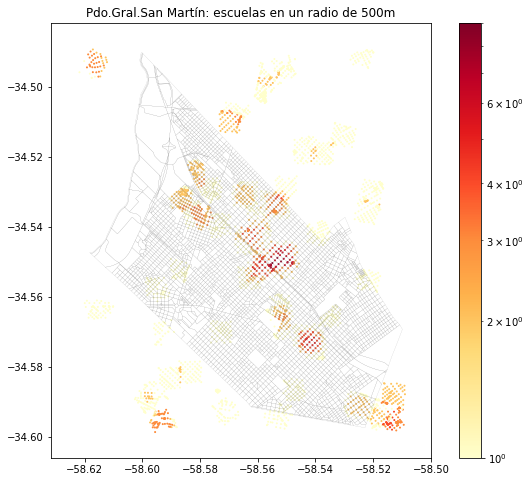

In [15]:
# para ver cantidad de escuelas (ojo la escala logaritmica)
fig, ax = plt.subplots(figsize=(10,8))

plt.title('Pdo.Gral.San Martín: escuelas en un radio de 500m')
plt.scatter(network.nodes_df.x, network.nodes_df.y, 
            c=accessibility, s=1, cmap='YlOrRd', 
            norm=matplotlib.colors.LogNorm()
            )
cb = plt.colorbar()
polyg.geometry.boundary.to_crs(4326).plot(ax=ax, linewidth=0.1, color='grey')
plt.show()

Para aquellos que no estén muy familiarizados con la lectura de escalas logarítmicas, recomendamos la [siguiente](https://blog.datawrapper.de/weeklychart-logscale2/) lectura.

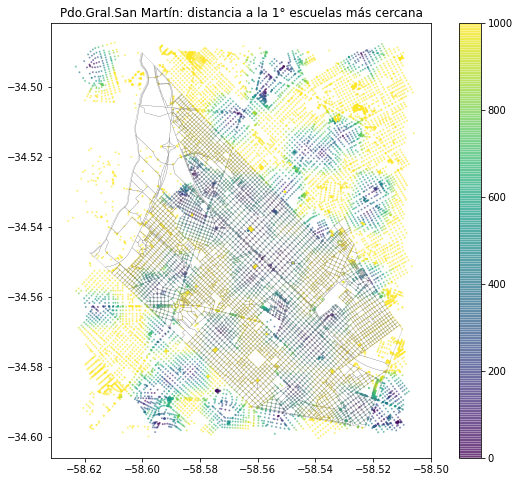

In [16]:
# ... o distancia a la escuela mas cercana
fig, ax = plt.subplots(figsize=(10,8))

plt.title('Pdo.Gral.San Martín: distancia a la 1° escuelas más cercana')
plt.scatter(network.nodes_df.x, network.nodes_df.y, 
            c=results[1], s=1, cmap='viridis',alpha=0.5
            )
cb = plt.colorbar()
polyg.geometry.boundary.to_crs(4326).plot(ax=ax, linewidth=0.2, color='grey')
plt.show()

### 3. Creo una referencia de demanda para los puntos de interés

In [18]:
path = '/drive/MyDrive/Gestion de ciudades/data/censo_2010/radios_rmba.geojson'
rmba = gpd.read_file(path)

In [19]:
# ponemos estos resultados, en contexto poblacional
smartin = rmba.loc[rmba.link.apply(lambda x: x[:5]=='06371')].copy().to_crs(4326)

In [20]:
# creamos una referencia x/y al centroide del radio
smartin['x'] = smartin.geometry.centroid.x
smartin['y'] = smartin.geometry.centroid.y

In [21]:
# y le asignamos el nodo mas cercano al centroide del poligono
smartin['node_id'] = network.get_node_ids(smartin['x'],smartin['y'])

In [22]:
smartin.columns

Index(['link', 'varon', 'mujer', 'personas', 'hogares', 'viv_part',
       'viv_part_hab', 'densidad', 'geometry', 'x', 'y', 'node_id'],
      dtype='object')

In [23]:
# para determinar ahora, la cantidad de hogares en un radio x a los nodos de la red
network.set(smartin.node_id,  
            variable=smartin['hogares'])
dist = 1
agg_dist = dist*1000
results2 = network.aggregate(agg_dist, type='sum', decay='linear')

In [24]:
results2.describe()

count    14272.000000
mean       692.572733
std        843.699832
min          0.000000
25%          0.000000
50%         90.254218
75%       1464.965950
max       3135.266796
dtype: float64

In [25]:
smartin['hogares_1km'] = smartin['node_id'].map(results2)

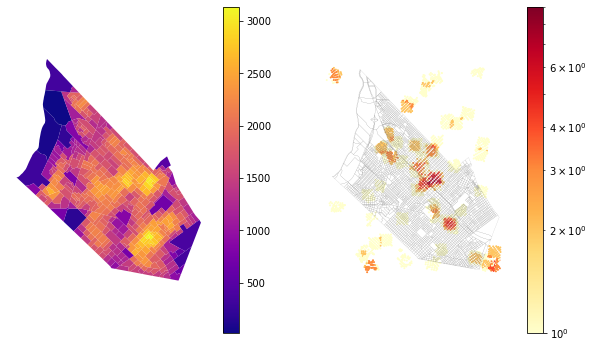

In [26]:
# y ahora si, vemos cómo se distribuyen tanto escuelas como población
f = plt.figure(figsize=(10,6))
ax1 = f.add_subplot(1,2,1)
ax2 = f.add_subplot(1,2,2)

c = smartin.plot(ax=ax1, column='hogares_1km', cmap='plasma', 
                 legend=True)

s = ax2.scatter(network.nodes_df.x, network.nodes_df.y, 
                c=accessibility, s=1, cmap='YlOrRd', 
                norm=matplotlib.colors.LogNorm(),
                ) 
cbII = plt.colorbar(s)
polyg.geometry.boundary.to_crs(4326).plot(ax=ax2, linewidth=0.1, color='grey')

ax1.set_axis_off()
ax2.set_axis_off();